# Setup

In [1]:
import pandas as pd
import json
import IPython
from ita_deidentification import anonymizer
from os import path, listdir
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test_folder_path = './anonymisation_letters/'
config_path = './configs/regex.json'
with open(config_path, 'r') as json_file:
    config_dict = json.load(json_file)
config_name = config_dict['name']
print('config name:', config_name)
deid = anonymizer(config_path)


config name: regex
new config: {'name': 'regex', 'models': {'telephone': 'regex', 'zipcode': 'regex', 'email': 'regex', 'fiscal_code': 'regex', 'date': 'regex', 'age': 'regex'}, 'mask': {'mode': 'anon_l', 'special_character': '*', 'date_level': 'hide'}}
prev_models: {''}
{'telephone': 'regex', 'zipcode': 'regex', 'email': 'regex', 'fiscal_code': 'regex', 'person': '', 'organization': '', 'address': '', 'date': 'regex', 'age': 'regex'}
DOWNLOADING AND INITIALIZING MODELS --------------------------------------------


In [3]:
def compute_scores(predictions, targets, confusion_only=False):
    tp = 0
    fp = 0
    fn = 0
    targets = targets.copy()
    for prediction in predictions:
        if prediction in targets:
            tp += 1
            targets.remove(prediction)
        else:
            fp += 1
    fn += len(targets)
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    if confusion_only:
        return { 'tp': tp, 'fp': fp, 'fn': fn }
    else:
        return { 'precision': precision, 'recall': recall, 'f1': f1 }


def compute_scores_document(df_predictions, df_targets):
    # strict calculation
    df_predictions['strict_pos'] = df_predictions.start.astype(str) + '-' + df_predictions.end.astype(str)
    df_targets['strict_pos'] = df_targets.start.astype(str) + '-' + df_targets.end.astype(str)

    strict_scores_dict = {}
    for entity_type in df_targets.entity_type.unique():
        strict_scores_dict[entity_type] = compute_scores(df_predictions.loc[df_predictions.entity_type == entity_type,'strict_pos'].to_list(), df_targets.loc[df_targets.entity_type == entity_type, 'strict_pos'].to_list())

    # lenient calculation
    def overlap(a, b):
        if max(0, min(a[1], b[1]) - max(a[0], b[0])) != 0:
            return True
        else:
            return False

    lenient_scores_dict = {}
    for entity_type in df_targets.entity_type.unique():
        # print('compute score for entity_type:', entity_type)
        prediction_lenient_match = []
        for pred_index, prediction in df_predictions.loc[df_predictions.entity_type == entity_type].iterrows():
            for target_index, target in df_targets.loc[df_targets.entity_type == entity_type].iterrows():
                prediction_pos = [prediction['start'], prediction['end']]
                target_pos = [target['start'], target['end']]
                if overlap(prediction_pos, target_pos):
                    prediction_lenient_match.append(target_index)
        
        prediction_lenient_match = list(set(prediction_lenient_match))

        prediction_lenient_match = prediction_lenient_match + [None] * (len(df_predictions.loc[df_predictions.entity_type == entity_type]) - len(prediction_lenient_match))
        # print('prediction_lenient_match:', prediction_lenient_match)
        # print('target indexes', df_targets.index[df_targets.entity_type == entity_type].tolist())
        lenient_scores_dict[entity_type] = compute_scores(
            prediction_lenient_match,
            df_targets.index[df_targets.entity_type == entity_type].tolist()
        )

    return {'strict': strict_scores_dict, 'lenient': lenient_scores_dict}

In [4]:
test_filename_text_list = [filename for filename in listdir(test_folder_path) if '.txt' in filename and '_' not in filename]
test_filename_text_list.sort()
test_filename_anon_list = [filename for filename in listdir(test_folder_path) if 'anon.csv' in filename]
test_filename_anon_list.sort()

In [5]:
# df_prova = pd.DataFrame()
# for filename in test_filename_anon_list:
#     df_tmp = pd.read_csv(test_folder_path + filename, sep=';', names=['start', 'end', 'entity_type'])
#     # print(df_tmp.head())
#     # break
#     df_prova = pd.concat([df_prova, df_tmp])
# list(df_prova.entity_type.unique())

# Evaluation of all documents

In [14]:
index_named_entity = [
    'TEL',
    'ZIP',
    'EMAIL',
    'NAME',
    'ORG',
    'LOC',
    'DATE',
    'CF',
    'AGE'
]
corpus_scores_lenient_dict = {key: dict(precision=[], recall=[], f1=[]) for key in index_named_entity}
corpus_scores_strict_dict = {key: dict(precision=[], recall=[], f1=[]) for key in index_named_entity}
for filename_anon, filename_text in zip(test_filename_anon_list, test_filename_text_list):
    # load text
    with open(test_folder_path + filename_text, 'r') as file:
        text = ''.join(file.readlines())
    # perform inference and retrieve spans
    output = deid.deIdentificationIta(text)
    df_predictions = output['match_dataframe']
    # df_predictions.end = df_predictions.end + 1
    # create a dataframe with start, end, entity_type, text as columns
    # df_predictions = pd.DataFrame()
    # for entity_type in output_dict['spans_dict']:
        
    #     start_list = [int(pos[0]) for pos in output_dict['spans_dict'][entity_type]]
    #     end_list = [int(pos[1]) for pos in output_dict['spans_dict'][entity_type]]
    #     text_list = [text[int(pos[0]):int(pos[1])] for pos in output_dict['spans_dict'][entity_type]]

    #     df_tmp = pd.DataFrame(
    #         {
    #             'start': start_list,
    #             'end': end_list,
    #             'entity_type': [entity_type]*len(start_list),
    #             'text': text_list
    #         }
    #     )
    #     df_predictions = pd.concat([df_predictions, df_tmp])

    # df_predictions.start = df_predictions.start.astype(int)
    # df_predictions.end = df_predictions.end.astype(int)

    # df_predictions.reset_index(drop=True, inplace=True)
    # change names of the entity_types to be consistent with targets entity_types
    df_predictions['entity_type'] = df_predictions['entity_type'].replace(
        [
            'TELEFONO',
            'CAP',
            'E-MAIL',
            'PERSONA',
            'ORGANIZZAZIONE',
            'INDIRIZZO',
            'DATA',
            'CF',
            'ETÀ'
        ],
        [
            'TEL',
            'ZIP',
            'EMAIL',
            'NAME',
            'ORG',
            'LOC',
            'DATE',
            'CF',
            'AGE'
        ]
    )
    
    # load the gold standard annotations
    df_targets = pd.read_csv(test_folder_path + filename_anon, sep=';', names=['start', 'end', 'entity_type'])
    df_targets.end = df_targets.end + 1
    df_targets['text'] = df_targets.apply(lambda row: text[row['start']:row['end']], axis=1)
    df_targets['entity_type'] = df_targets['entity_type'].replace(
        [
            'YEAR'
        ],
        [
            'DATE'
        ]
    )

    # compute the scores of the single document
    scores_dict = compute_scores_document(df_predictions, df_targets)
    
    # insert the lenient scores in a aggregated list
    for entity_type in scores_dict['lenient']:
        for score_type in ['precision','recall', 'f1']:
            corpus_scores_lenient_dict[entity_type][score_type].append(scores_dict['lenient'][entity_type][score_type])
    # insert the strict scores in a aggregated list
    for entity_type in scores_dict['strict']:
        for score_type in ['precision','recall', 'f1']:
            corpus_scores_strict_dict[entity_type][score_type].append(scores_dict['strict'][entity_type][score_type])

# create the dataframe of the scores of the corpus
df_corpus_scores_lenient = pd.DataFrame(index=index_named_entity, columns=['precision', 'recall', 'f1'])
df_corpus_scores_strict = pd.DataFrame(index=index_named_entity, columns=['precision', 'recall', 'f1'])

# compute the avg of the scores: correspond to a macro average 
for entity_type in index_named_entity:
    for score_type in ['precision','recall', 'f1']:

        score_list_lenient = corpus_scores_lenient_dict[entity_type][score_type]
        if score_list_lenient != []:
            df_corpus_scores_lenient.loc[entity_type, score_type] = sum(score_list_lenient)/len(score_list_lenient)

        score_list_strict = corpus_scores_strict_dict[entity_type][score_type]
        if score_list_strict != []:
            df_corpus_scores_strict.loc[entity_type, score_type] = sum(score_list_strict)/len(score_list_strict)

# drop entity types that never appears 
df_corpus_scores_lenient.dropna(inplace=True)
df_corpus_scores_strict.dropna(inplace=True)

df_corpus_scores_lenient.recall = df_corpus_scores_lenient.recall.astype(float)
df_corpus_scores_lenient.precision = df_corpus_scores_lenient.precision.astype(float)
df_corpus_scores_lenient.f1 = df_corpus_scores_lenient.f1.astype(float)

df_corpus_scores_strict.recall = df_corpus_scores_strict.recall.astype(float)
df_corpus_scores_strict.precision = df_corpus_scores_strict.precision.astype(float)
df_corpus_scores_strict.f1 = df_corpus_scores_strict.f1.astype(float)

    

   start   end entity_type        text  model
0   7582  7587         CAP       24457  regex
0     53    63        DATA  19.02.1964  regex
1    107   117        DATA  28.07.2021  regex
2    403   413        DATA  19.07.2021  regex
3    991   999        DATA    24/05/21  regex
4   2498  2506        DATA    05.07.21  regex
5   2534  2542        DATA    19.07.21  regex
6   2591  2599        DATA    05.07.21  regex
7   2697  2705        DATA    05.07.21  regex
8   2744  2752        DATA    19.07.21  regex
9   2854  2857        DATA         1.1  regex
11  3453  3456        DATA         9.1  regex
12  3587  3590        DATA         9.1  regex
13  3720  3728        DATA    19.07.21  regex
14  3790  3798        DATA    20.07.21  regex
15  4101  4109        DATA    21.07.21  regex
16  4294  4302        DATA    27.07.21  regex
17  4460  4468        DATA    27.07.21  regex
18  5390  5400        DATA  25.07.2021  regex
19  5403  5413        DATA  27.07.2021  regex
20  5759  5763        DATA        

ValueError: could not convert string to float: 'TEL'

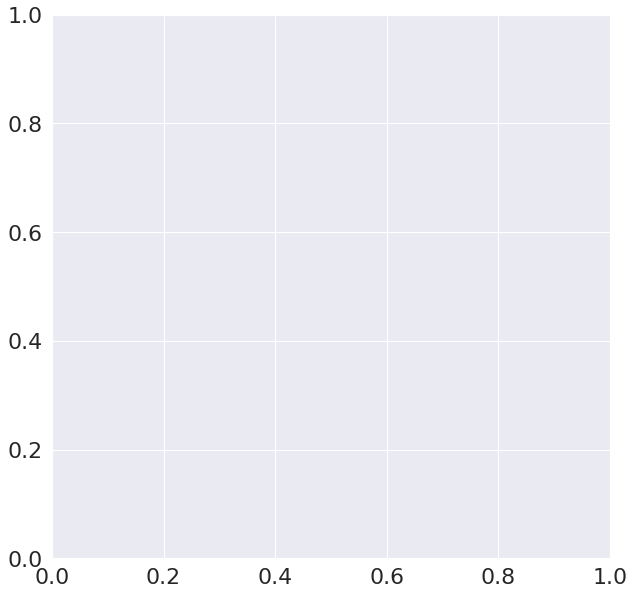

In [15]:
# plot the heatmap of the lenient scores
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_corpus_scores_lenient, cmap='RdYlGn', annot=True, fmt=".2f", annot_kws={"fontsize":20}, vmin=0, vmax=1)
fig.savefig(f'./evaluations/{config_name}_lenient_heat_scores.png', dpi=400, bbox_inches='tight')

In [11]:
df_predictions

,start,end,entity_type,text,model,strict_pos
0,54,63,DATE,9.04.2020,regex,54-63
1,279,283,DATE,1/13,regex,279-283
2,776,780,DATE,20-1,regex,776-780
3,781,785,DATE,90-1,regex,781-785
4,786,790,DATE,80-2,regex,786-790
5,791,795,DATE,10-2,regex,791-795
8,890,894,DATE,1.73,regex,890-894
23,1202,1207,DATE,12-39,regex,1202-1207
24,1295,1304,DATE,3.04.2020,regex,1295-1304
25,1490,1494,DATE,5-10,regex,1490-1494


In [12]:
df_targets

,start,end,entity_type,text,strict_pos
0,54,63,DATE,9.04.2020,54-63
1,1295,1304,DATE,3.04.2020,1295-1304
2,1505,1515,DATE,06.04.2020,1505-1515


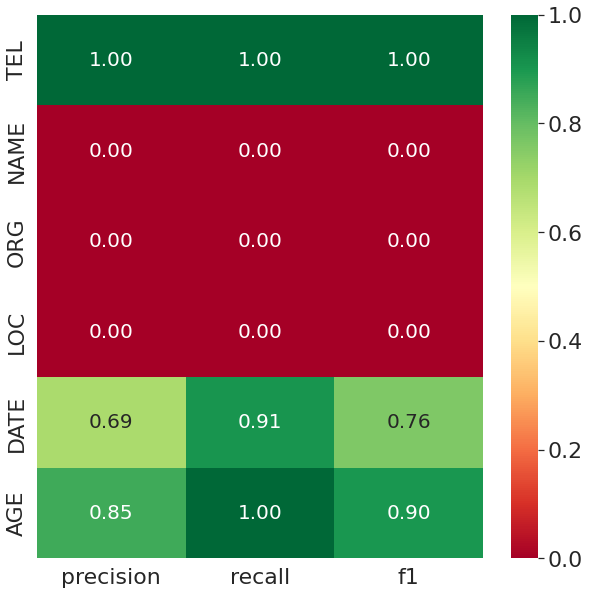

In [14]:
# plot the heatmap of the lenient scores
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_corpus_scores_strict, cmap='RdYlGn', annot=True, fmt=".2f", annot_kws={"fontsize":20}, vmin=0, vmax=1)
fig.savefig(f'./evaluations/{config_name}_strict_heat_scores.png', dpi=400, bbox_inches='tight')

# evaluation of one document

In [31]:
with open(test_folder_path + test_filename_text_list[0], 'r') as file:
    text = ''.join(file.readlines())

In [32]:
output = deid.deIdentificationIta(text)

In [33]:
df_predictions = output['match_dataframe']

In [81]:
# df_predictions = pd.DataFrame()
# for entity_type in output_dict['spans_dict']:
#     start_list = [int(pos[0]) for pos in output_dict['spans_dict'][entity_type]]
#     end_list = [int(pos[1]) for pos in output_dict['spans_dict'][entity_type]]
#     text_list = [text[int(pos[0]):int(pos[1])] for pos in output_dict['spans_dict'][entity_type]]
#     df_tmp = pd.DataFrame({'start': start_list, 'end': end_list, 'entity_type': [entity_type]*len(start_list), 'text': text_list})
#     df_predictions = pd.concat([df_predictions, df_tmp])

In [82]:
# df_predictions.start = df_predictions.start.astype(int)
# df_predictions.end = df_predictions.end.astype(int)

In [83]:
# df_predictions.reset_index(drop=True, inplace=True)

In [34]:
df_predictions['entity_type'] = df_predictions['entity_type'].replace(
    [
        'TELEFONO',
        'CAP',
        'E-MAIL',
        'PERSONA',
        'ORGANIZZAZIONE',
        'INDIRIZZO',
        'DATA',
        'CF',
        'ETÀ'
    ],
    [
        'TEL',
        'ZIP',
        'EMAIL',
        'NAME',
        'ORG',
        'LOC',
        'DATE',
        'CF',
        'AGE'
    ]
)

In [35]:
df_predictions

,start,end,entity_type,text
0,53,63,TEL,19.02.1964
1,107,117,TEL,28.07.2021
2,403,413,TEL,19.07.2021
3,5390,5400,TEL,25.07.2021
4,5403,5413,TEL,27.07.2021
5,6781,6791,TEL,08.04.1988
0,7582,7587,ZIP,24457
0,32,43,NAME,Marta Rossi
1,77,96,LOC,San Donato Milanese
2,98,104,LOC,Milano


In [43]:
df_targets = pd.read_csv(test_folder_path + test_filename_anon_list[0], sep=';', names=['start', 'end', 'entity_type'])

In [44]:
df_targets.head()

,start,end,entity_type
0,32,42,NAME
1,53,62,DATE
2,77,95,LOC
3,98,103,LOC
4,107,116,DATE


In [45]:
df_targets.end = df_targets.end + 1
df_targets['text'] = df_targets.apply(lambda row: text[row['start']:row['end']], axis=1)

df_targets['entity_type'] = df_targets['entity_type'].replace(
    [
        'YEAR'
    ],
    [
        'DATE'
    ]
)


In [46]:
df_targets

,start,end,entity_type,text
0,32,43,NAME,Marta Rossi
1,53,63,DATE,19.02.1964
2,77,96,LOC,San Donato Milanese
3,98,104,LOC,Milano
4,107,117,DATE,28.07.2021
5,274,279,LOC,Aosta
6,325,336,NAME,Marta Rossi
7,341,348,AGE,anni 74
8,403,413,DATE,19.07.2021
9,991,999,DATE,24/05/21


In [47]:
scores_dict = compute_scores_document(df_predictions, df_targets)

In [48]:
index_named_entity = [
    'TEL',
    'ZIP',
    'EMAIL',
    'NAME',
    'ORG',
    'LOC',
    'DATE',
    'CF',
    'AGE'
]

df_scores = pd.DataFrame(index=index_named_entity, columns=['precision', 'recall', 'f1'])
for entity_type in scores_dict['lenient']:
    df_scores.loc[entity_type, 'recall'] = scores_dict['lenient'][entity_type]['recall']
    df_scores.loc[entity_type, 'precision'] = scores_dict['lenient'][entity_type]['precision']
    df_scores.loc[entity_type, 'f1'] = scores_dict['lenient'][entity_type]['f1']

In [49]:
df_scores.dropna(inplace=True)

In [50]:
df_scores.recall = df_scores.recall.astype(float)
df_scores.precision = df_scores.precision.astype(float)
df_scores.f1 = df_scores.f1.astype(float)

<AxesSubplot: >

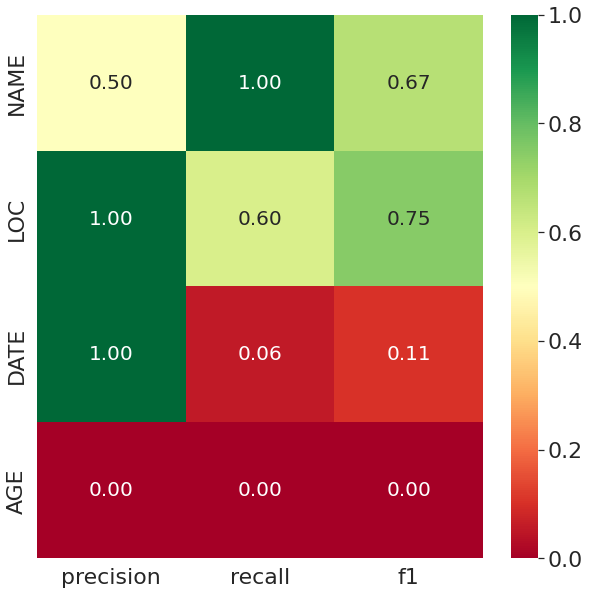

In [51]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_scores, cmap='RdYlGn', annot=True, fmt=".2f", annot_kws={"fontsize":20}, vmin=0, vmax=1)
# fig.savefig(f'QUESTIONS_heat.png', dpi=400, transparent=True, bbox_inches='tight')